In [1]:
import os
import random
from itertools import combinations
import numpy as np
import pandas as pd
from collections import namedtuple
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [2]:
Individual = namedtuple('Individual', ['genotype', 'fitness'])

In [ ]:
NPY_FOLDER_PATH = "lab2_npy"

POPULATION_SIZE = 100 # number of individuals in the population
OFFSPRING_SIZE = 40 # number of offspring individuals

TOURNAMENT_SIZE = 10 # τ
CROSSOVER_RATE = 0.9 # probability of crossover
MUTATION_RATE = 0.1 # probability of mutation

CONVERGENCE_LIMIT = 100 # maximum number of generations without improvement

GREEDY_PERCENT = 0.50  # percentage of greedy solutions in the initial population

# Cost Function

In [4]:
def calculate_cost(genotype: list[int], cost_matrix: np.ndarray) -> float:
    """
    Calculate the total cost of a TSP route represented by the genotype.
    """
    total_cost = 0.0
    num_cities = len(genotype)
    for i in range(num_cities):
        city1 = genotype[i]
        city2 = genotype[(i + 1) % num_cities]  # wrap-around to the starting city
        total_cost += cost_matrix[city1, city2]
    return total_cost

def calculate_fitness(cost: float) -> float:
    """
    Calculate the fitness from the cost. Since we want to minimize cost
    and maximize fitness, we take the negative of the cost.
    """ 
    return -cost

# Initialize population

In [5]:
def create_nearest_neighbor_solution(cost_matrix: np.ndarray, start_node: int) -> list[int]:
    """
    Create a TSP solution using the nearest neighbor heuristic starting from start_node.
    """
    num_cities = cost_matrix.shape[0]
    tour = [start_node] # start from the given start node
    unvisited = set(range(num_cities))
    unvisited.remove(start_node)

    current_city = start_node
    while unvisited:
        # Find the nearest unvisited city
        next_city = min(unvisited, key=lambda x: cost_matrix[current_city, x])
        unvisited.remove(next_city)
        tour.append(next_city)
        current_city = next_city
    return tour

In [6]:
def create_random_solution(num_cities: int) -> list[int]:
    """
    Create a random TSP solution.
    """
    genotype = list(range(num_cities))
    np.random.shuffle(genotype)
    return genotype

In [7]:
def find_middle_start(cost_matrix: np.ndarray) -> int:
    """
    Find a starting node for the nearest neighbor heuristic based on the row with the minimum total cost.
    """
    min_row_index = -1
    min_row_cost = float('inf')

    for i in range(cost_matrix.shape[0]):
        cost = np.sum(cost_matrix[i]) - cost_matrix[i][i]
        if cost < min_row_cost:
            min_row_cost = cost
            min_row_index = i

    return min_row_index

In [ ]:
def initialize_population(cost_matrix: np.ndarray) -> list[Individual]:
    """
    Initialize the population with a mix of nearest neighbor and random solutions.
    """
    num_cities = cost_matrix.shape[0]
    population = []

    # 1. greedy fixed solutions (start in the middle)
    start_node_middle = find_middle_start(cost_matrix)
    genotype_greedy_middle = create_nearest_neighbor_solution(cost_matrix, start_node_middle)
    fitness_greedy_middle = calculate_fitness(calculate_cost(genotype_greedy_middle, cost_matrix))
    population.append(Individual(genotype_greedy_middle, fitness_greedy_middle))

    # 2. ordered solutions
    genotype_ordered = list(range(num_cities))
    fitness_ordered = calculate_fitness(calculate_cost(genotype_ordered, cost_matrix))
    population.append(Individual(genotype_ordered, fitness_ordered))

    # 3. reversed ordered solutions
    genotype_reversed = list(reversed(range(num_cities)))
    fitness_reversed = calculate_fitness(calculate_cost(genotype_reversed, cost_matrix))
    population.append(Individual(genotype_reversed, fitness_reversed))

    # 4. add greedy random solutions
    desired_greedy_count = int(POPULATION_SIZE * GREEDY_PERCENT)
    num_greedy_random_to_create = desired_greedy_count - 1  # subtract the 1 fixed greedy solution already added
    used_start_nodes = {start_node_middle}
    available_start_nodes = [n for n in range(num_cities) if n not in used_start_nodes]
    num_greedy_random_to_create = min(num_greedy_random_to_create, len(available_start_nodes))

    if num_greedy_random_to_create > 0:
        # select random start nodes from the available ones
        start_nodes = random.sample(available_start_nodes, num_greedy_random_to_create)
        for start_node in start_nodes: 
            g_greedy_random = create_nearest_neighbor_solution(cost_matrix, start_node)
            population.append(Individual(g_greedy_random, calculate_fitness(calculate_cost(g_greedy_random, cost_matrix))))

    num_random_to_add = POPULATION_SIZE - len(population)

    # 5. add random solutions
    for _ in range(num_random_to_add):
        g_random = create_random_solution(num_cities)
        population.append(Individual(g_random, calculate_fitness(calculate_cost(g_random, cost_matrix))))

    return population

# Tournament selection

In [9]:
def tournament_selection(population: list[Individual], k: int) -> Individual:
    """
    Perform tournament selection to choose one individual from the population.
    """
    # Select k individuals randomly from the population
    pool = random.sample(population, k)
    # Return the best (highest fitness) among them
    return max(pool, key=lambda i: i.fitness)

# Crossover

In [10]:
def order_crossover_ox(p1_geno: list[int], p2_geno: list[int]) -> list[int]:
    """
    Perform Order Crossover (OX) between two parent genotypes to produce a child genotype.
    """
    size = len(p1_geno)
    child = [None] * size
    
    # select two random crossover points
    start, end = sorted(random.sample(range(size), 2))

    # copy the segment from p1 to the child
    # end index is inclusive in OX
    child[start:end+1] = p1_geno[start:end+1]

    # create the list of cities from p2 (in order)
    p2_cities_to_add = []
    for city in p2_geno:
        if city not in child: # if not already in the segment
            p2_cities_to_add.append(city)

    # fill in the remaining positions in the child with cities from p2 (circularly)
    p2_idx = 0
    for i in range(size):
        if child[i] is None:
            child[i] = p2_cities_to_add[p2_idx]
            p2_idx += 1
    return child

# Mutation

In [11]:
def inversion_mutation(genotype: list[int]) -> list[int]:
    """
    Perform inversion mutation on the given genotype.
    Select two random indices and invert the sublist between them.
    """
    g_copy = list(genotype) # work on a copy
    size = len(g_copy)
    
    # select two distinct random indices
    i, j = random.sample(range(size), 2)
    
    # ensure i < j
    start, end = min(i, j), max(i, j)
    
    # invert the sublist between start and end
    while start < end:
        g_copy[start], g_copy[end] = g_copy[end], g_copy[start]
        start += 1
        end -= 1
        
    return g_copy

# Insert in population with Hill Climber 

In [12]:
def hill_climber_insert(genotype: list[int], cost_matrix: np.ndarray) -> list[int]:
    """
    Perform Hill Climbing using the "insert" neighborhood operator.
    Try to improve the given genotype by moving cities to different positions.
    The computation of cost differences is optimized to avoid full recalculation.
    """
    num_cities = len(genotype)
    current_tour = list(genotype) # work on a copy
    
    indices = list(range(num_cities))
    
    improved = True
    while improved:
        improved = False
        random.shuffle(indices) # random order of cities to try         
        for i in indices: # index of the city to move
            
            # find city B and its neighbors A and C
            city_b = current_tour[i]
            city_a = current_tour[i-1] # previous 
            city_c = current_tour[(i+1) % num_cities] # successor
            
            # compute cost of removing B from its current position
            # cost of breaking A->B and B->C, and creating A->C
            cost_of_removal = (cost_matrix[city_a, city_c] - 
                               cost_matrix[city_a, city_b] - 
                               cost_matrix[city_b, city_c])
            
            best_j = -1
            best_delta = 0 # find best delta < 0
            
            # try to insert B in every other position 'j'
            # j = index of the position *before* which to insert B
            for j in range(num_cities):
                if i == j: # no sense in inserting before itself
                    continue

                # find the new neighbors X and Y
                # insert B between X and Y
                city_x = current_tour[j-1] 
                city_y = current_tour[j]
                
                # avoid reinserting it where it was already
                if city_x == city_b or city_y == city_b:
                    continue

                # calculate the cost of "inserting" B
                # cost of breaking X->Y, and creating X->B and B->Y
                cost_of_insertion = (cost_matrix[city_x, city_b] + 
                                     cost_matrix[city_b, city_y] - 
                                     cost_matrix[city_x, city_y])
                
                delta_cost = cost_of_removal + cost_of_insertion
                
                if delta_cost < best_delta:
                    best_delta = delta_cost
                    best_j = j # index to insert before
            
            # if found an improvement
            if best_delta < 0:
                # perform the move
                city_to_move = current_tour.pop(i)
                if i < best_j:
                    # index of insertion has shifted because we removed it
                    current_tour.insert(best_j - 1, city_to_move)
                else:
                    current_tour.insert(best_j, city_to_move)
                
                improved = True
                break
                
    return current_tour

# Run TSP Algorithm

In [13]:
'''
def property_test(problem):
    # Negative values?
    if np.any(problem < 0):
        print("Warning: The cost matrix contains negative values.")
    # Diagonal is all zero?
    if not np.allclose(np.diag(problem), 0.0):
        print("Warning: The diagonal of the cost matrix is not all zeros.")
    # Symmetric matrix?
    if not np.allclose(problem, problem.T):
        print("Warning: The cost matrix is not symmetric.")
    # Triangular inequality
    if not all(problem[x, y] <= problem[x, z] + problem[z, y]
       for x, y, z in list(combinations(range(problem.shape[0]), 3))):
      print("Warning: The cost matrix does not satisfy the triangular inequality.")
'''

'\ndef property_test(problem):\n    # Negative values?\n    if np.any(problem < 0):\n        print("Warning: The cost matrix contains negative values.")\n    # Diagonal is all zero?\n    if not np.allclose(np.diag(problem), 0.0):\n        print("Warning: The diagonal of the cost matrix is not all zeros.")\n    # Symmetric matrix?\n    if not np.allclose(problem, problem.T):\n        print("Warning: The cost matrix is not symmetric.")\n    # Triangular inequality\n    if not all(problem[x, y] <= problem[x, z] + problem[z, y]\n       for x, y, z in list(combinations(range(problem.shape[0]), 3))):\n      print("Warning: The cost matrix does not satisfy the triangular inequality.")\n'

In [14]:
def run_tsp_algorithm(cost_matrix: np.ndarray):
    """
    Run the TSP algorithm on the given problem instance.
    Returns the best cost found.
    """
    # Initialize population and get initial best solution
    population = initialize_population(cost_matrix)
    best_ever_individual = max(population, key=lambda i: i.fitness)
    best_cost = -best_ever_individual.fitness
    
    generation = 0
    generations_no_improvement = 0

    # Track history for plotting
    generation_history = [0]
    best_cost_history = [best_cost]
    
    # Evolution loop with progress bar
    pbar = tqdm(total=CONVERGENCE_LIMIT, desc="Generations without improvement", leave=False)

    while generations_no_improvement < CONVERGENCE_LIMIT:
        generation += 1
        
        # Offspring generation (λ = 40)
        offspring_pool = []
        for _ in range(OFFSPRING_SIZE):
            # Parent selection
            p1 = tournament_selection(population, TOURNAMENT_SIZE)
            p2 = tournament_selection(population, TOURNAMENT_SIZE)
            
            # Crossover
            if random.random() < CROSSOVER_RATE:
                child_genotype = order_crossover_ox(p1.genotype, p2.genotype)
            else:
                child_genotype = list(p1.genotype)
            
            # Mutation
            if random.random() < MUTATION_RATE:
                child_genotype = inversion_mutation(child_genotype)

            # Local optimization
            hc_probability = min(1.0, 100 / cost_matrix.shape[0])
            if random.random() < hc_probability:
                child_genotype = hill_climber_insert(child_genotype, cost_matrix)
            
            # Evaluation
            child_cost = calculate_cost(child_genotype, cost_matrix)
            child_fitness = calculate_fitness(child_cost)
            offspring_pool.append(Individual(child_genotype, child_fitness))

        # Survivor selection (μ + λ)
        population.extend(offspring_pool)
        population.sort(key=lambda i: i.fitness, reverse=True)
        population = population[:POPULATION_SIZE]

        # Update best solution
        current_best_individual = population[0]
        current_best_cost = -current_best_individual.fitness
        
        if current_best_cost < best_cost:
            best_cost = current_best_cost
            best_ever_individual = current_best_individual
            generations_no_improvement = 0
            pbar.reset()
        else:
            generations_no_improvement += 1
            pbar.update(1)

         # Record history every generation
        generation_history.append(generation)
        best_cost_history.append(best_cost)

    pbar.close()
    return best_cost, generation_history, best_cost_history

In [15]:
# Plotting function
def plot_convergence(generation_history, best_cost_history, problem_name, save_path=None):
    plt.figure(figsize=(10, 6))
    plt.plot(generation_history, best_cost_history, linewidth=2, color='#2E86AB')
    plt.xlabel('Generation', fontsize=12)
    plt.ylabel('Best Cost', fontsize=12)
    plt.title(f'Convergence Plot - {problem_name}', fontsize=14, fontweight='bold')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()

═══════════════════════════════════════
       TSP Algorithm Evaluation        
    Total instances to solve: 22     
═══════════════════════════════════════

[1/22] Processing problem_g_10.npy


Generations without improvement:   0%|          | 0/100 [00:00<?, ?it/s]

Best cost found: 1497.66


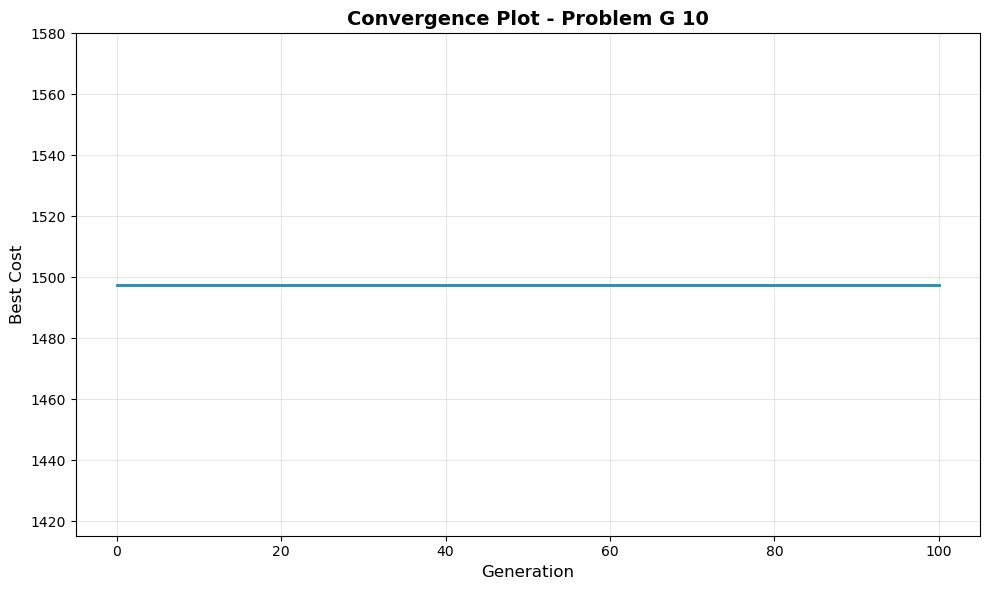

───────────────────────────────────────

[2/22] Processing problem_g_20.npy


Generations without improvement:   0%|          | 0/100 [00:00<?, ?it/s]

Best cost found: 1755.51


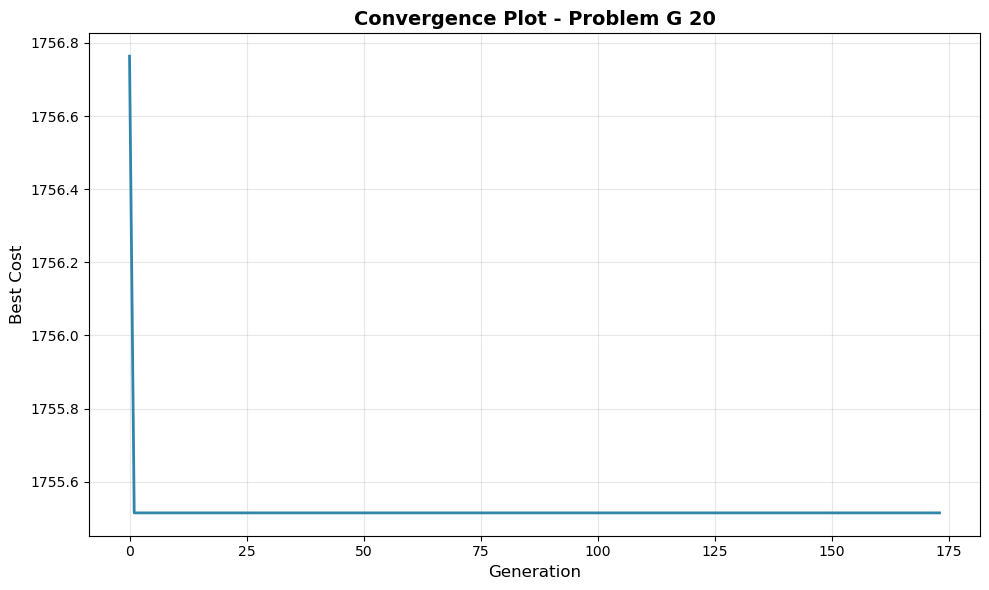

───────────────────────────────────────

[3/22] Processing problem_g_50.npy


Generations without improvement:   0%|          | 0/100 [00:00<?, ?it/s]

Best cost found: 2629.99


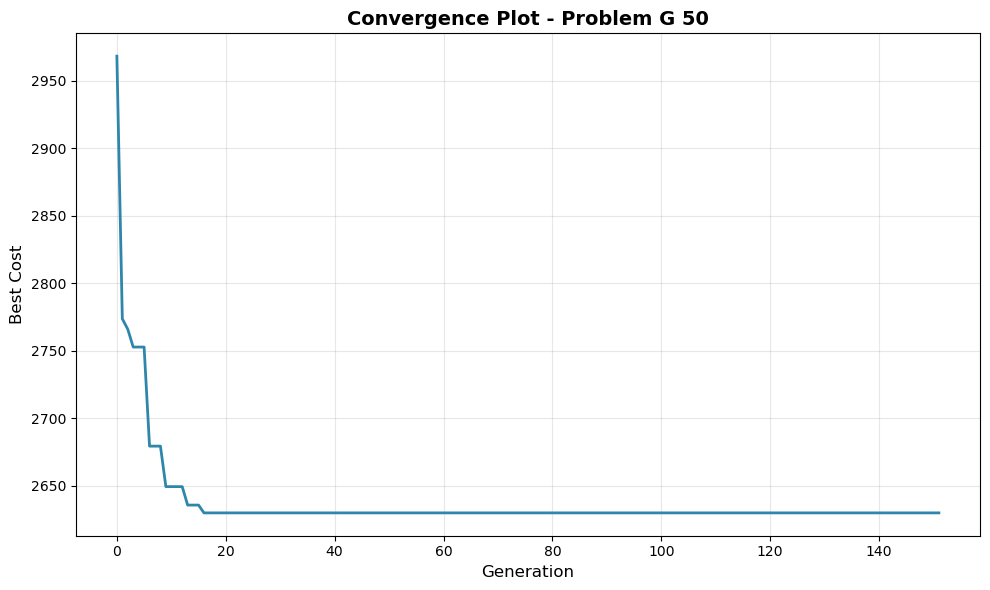

───────────────────────────────────────

[4/22] Processing problem_g_100.npy


Generations without improvement:   0%|          | 0/100 [00:00<?, ?it/s]

Best cost found: 3968.01


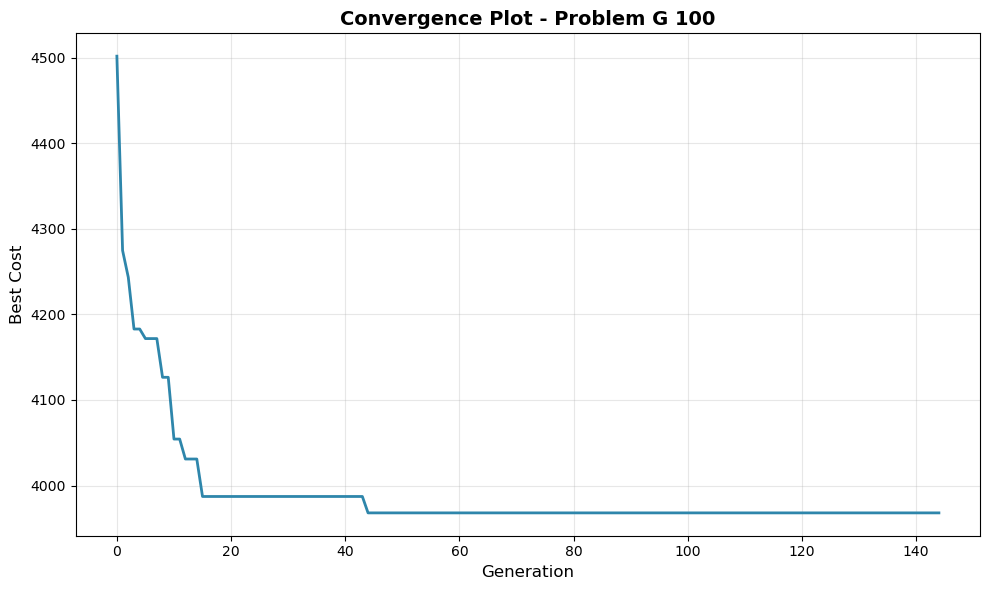

───────────────────────────────────────

[5/22] Processing problem_g_200.npy


Generations without improvement:   0%|          | 0/100 [00:00<?, ?it/s]

Best cost found: 5645.48


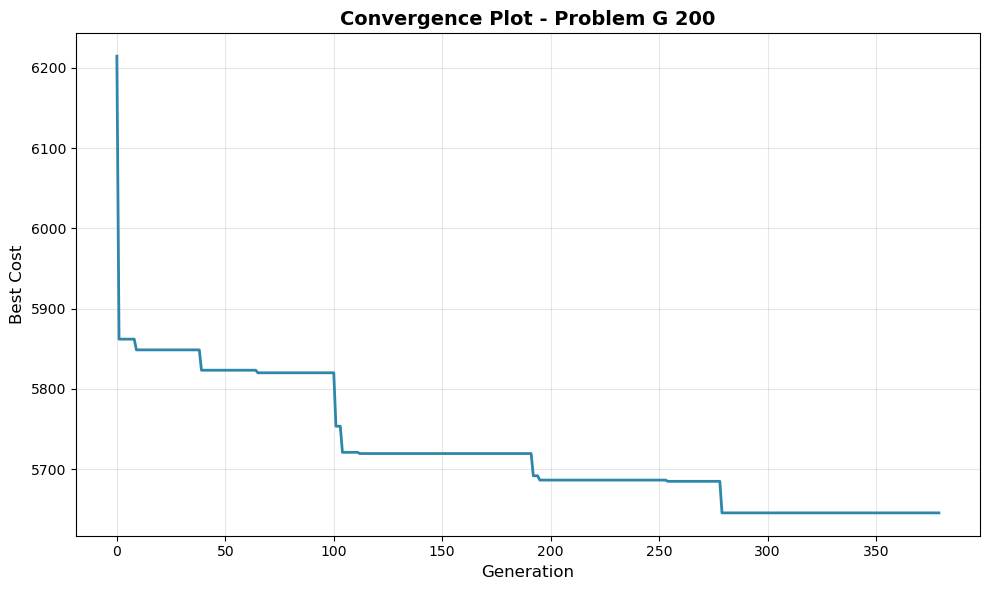

───────────────────────────────────────

[6/22] Processing problem_g_500.npy


Generations without improvement:   0%|          | 0/100 [00:00<?, ?it/s]

Best cost found: 8928.05


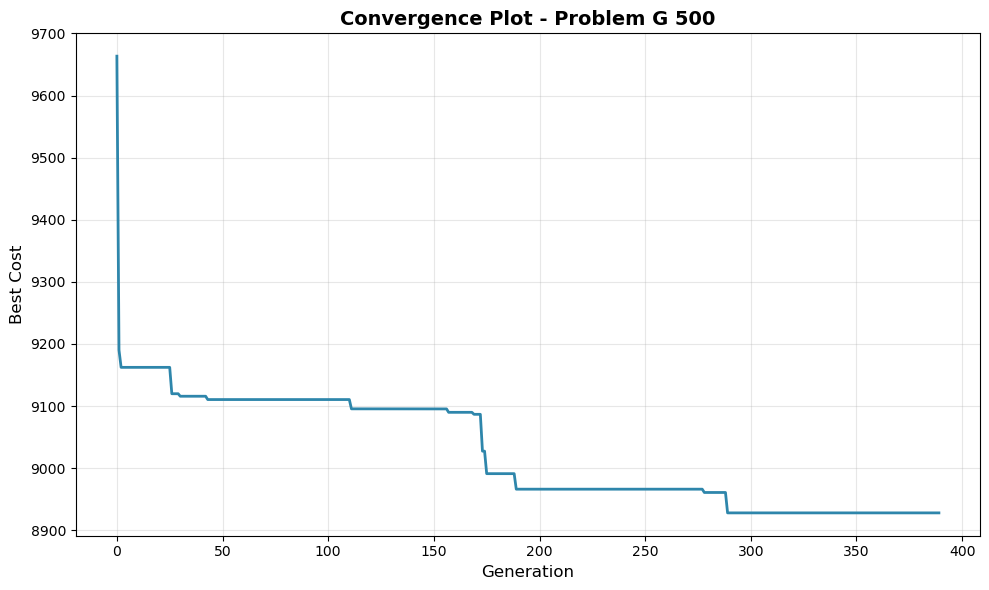

───────────────────────────────────────

[7/22] Processing problem_g_1000.npy


Generations without improvement:   0%|          | 0/100 [00:00<?, ?it/s]

Best cost found: 12957.82


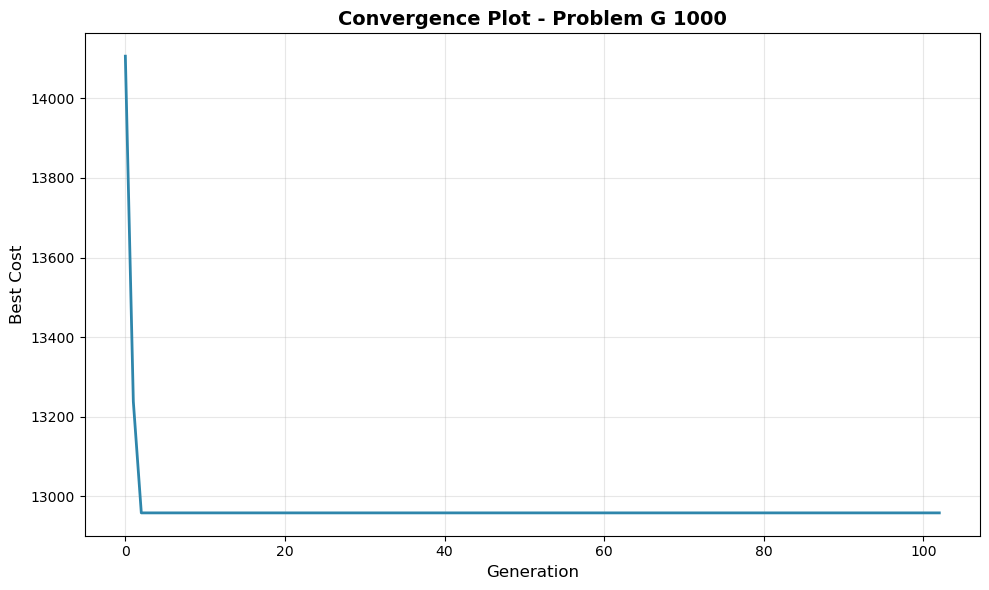

───────────────────────────────────────

[8/22] Processing problem_r1_10.npy


Generations without improvement:   0%|          | 0/100 [00:00<?, ?it/s]

Best cost found: 184.27


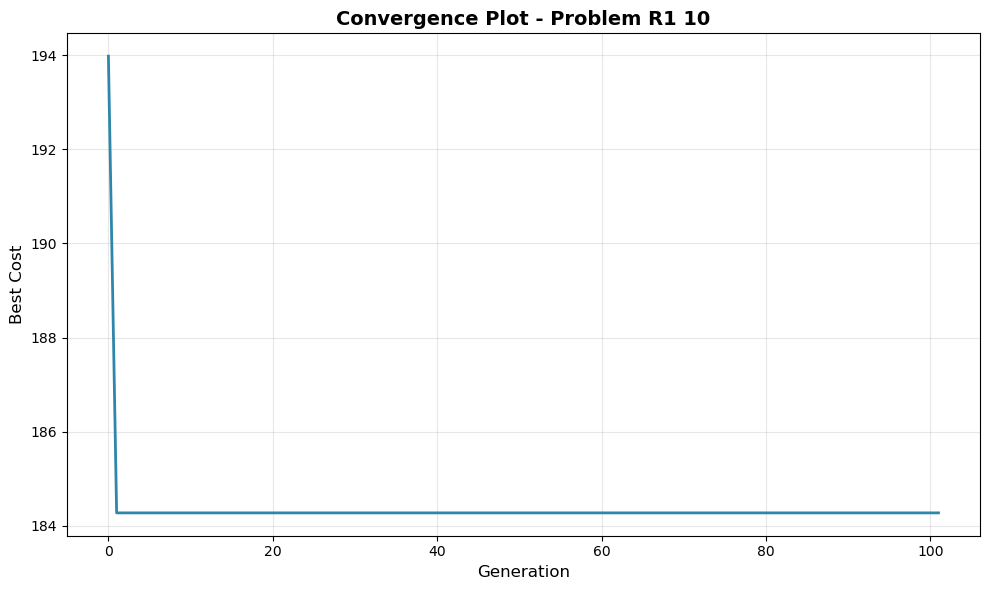

───────────────────────────────────────

[9/22] Processing problem_r1_20.npy


Generations without improvement:   0%|          | 0/100 [00:00<?, ?it/s]

Best cost found: 337.29


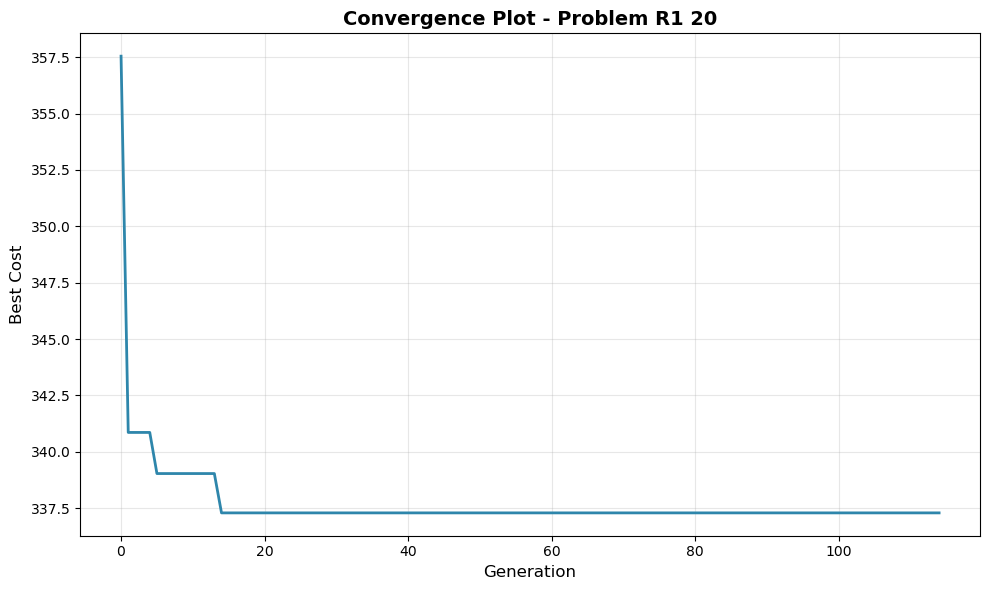

───────────────────────────────────────

[10/22] Processing problem_r1_50.npy


Generations without improvement:   0%|          | 0/100 [00:00<?, ?it/s]

Best cost found: 557.67


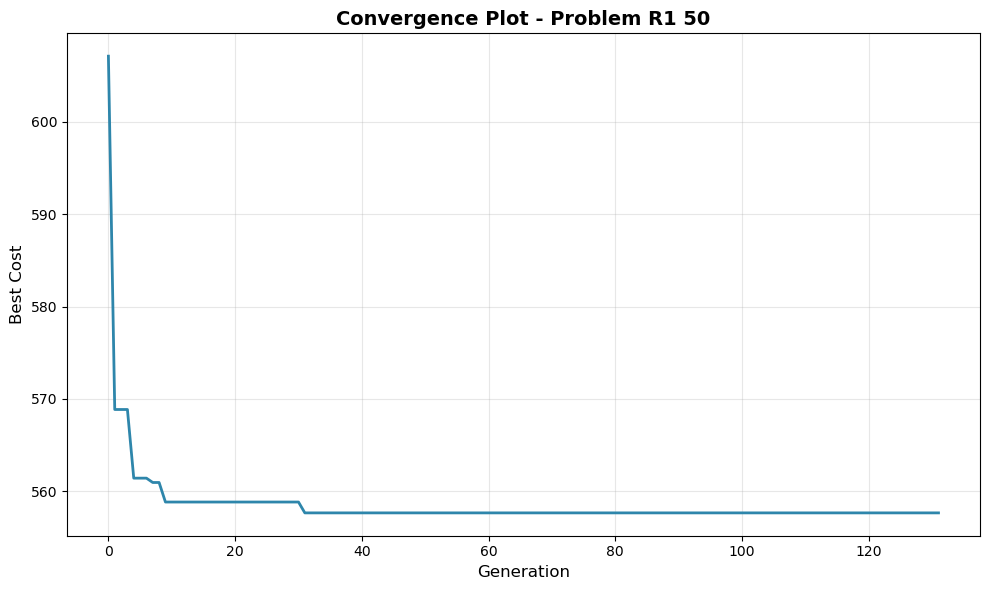

───────────────────────────────────────

[11/22] Processing problem_r1_100.npy


Generations without improvement:   0%|          | 0/100 [00:00<?, ?it/s]

Best cost found: 720.18


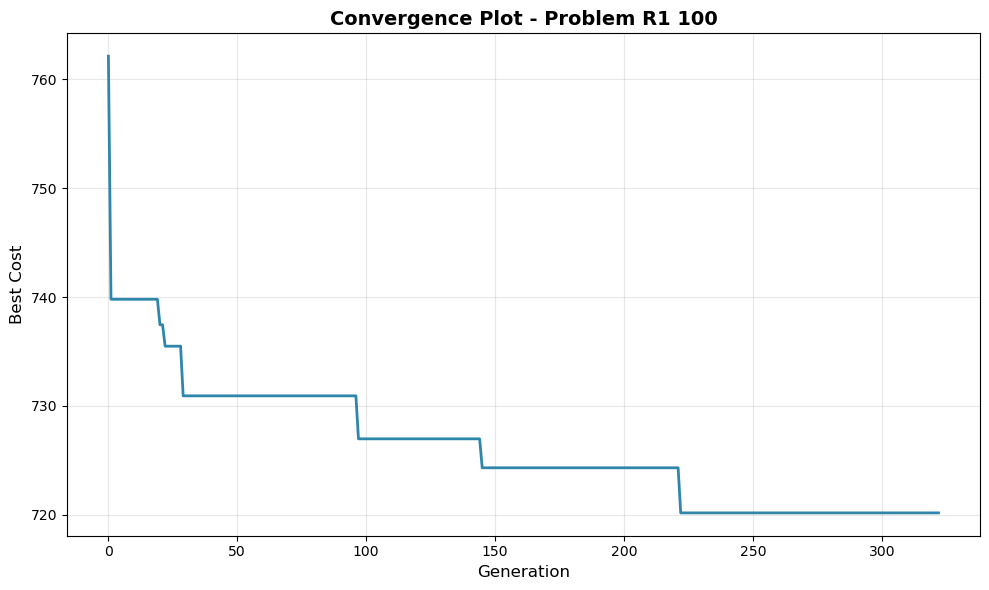

───────────────────────────────────────

[12/22] Processing problem_r1_200.npy


Generations without improvement:   0%|          | 0/100 [00:00<?, ?it/s]

Best cost found: 1027.21


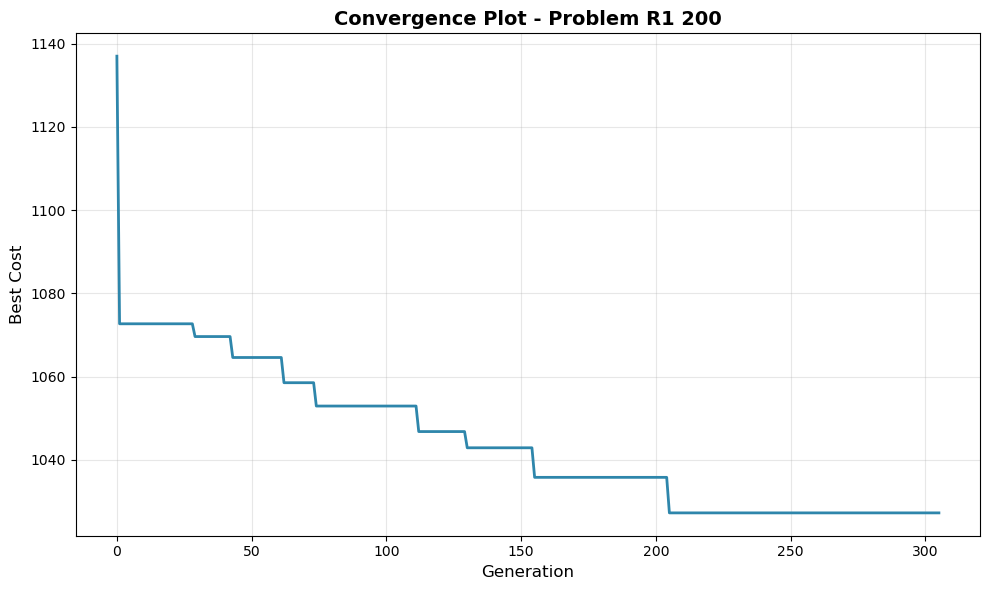

───────────────────────────────────────

[13/22] Processing problem_r1_500.npy


Generations without improvement:   0%|          | 0/100 [00:00<?, ?it/s]

Best cost found: 1639.68


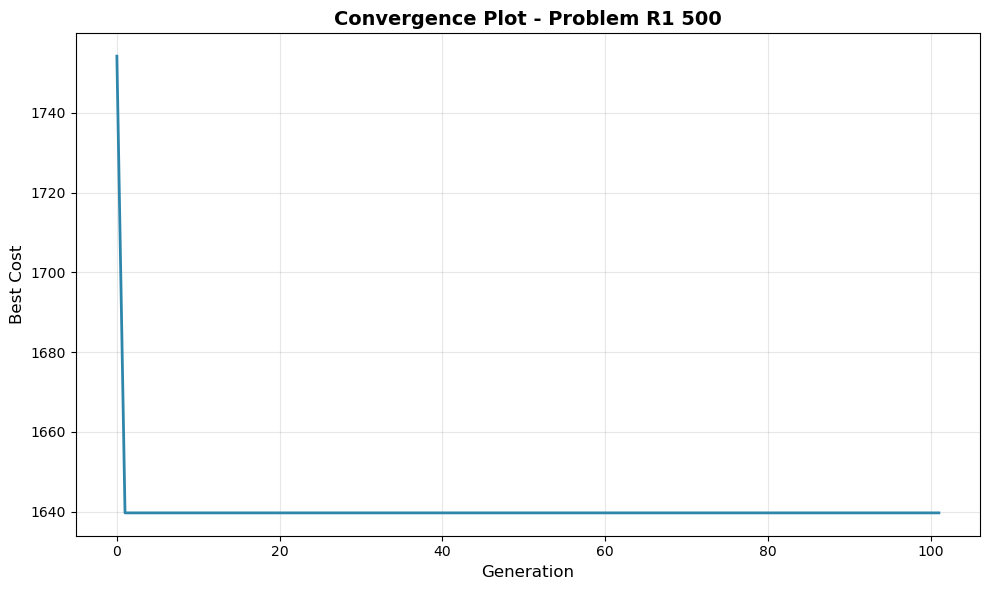

───────────────────────────────────────

[14/22] Processing problem_r1_1000.npy


Generations without improvement:   0%|          | 0/100 [00:00<?, ?it/s]

Best cost found: 2475.18


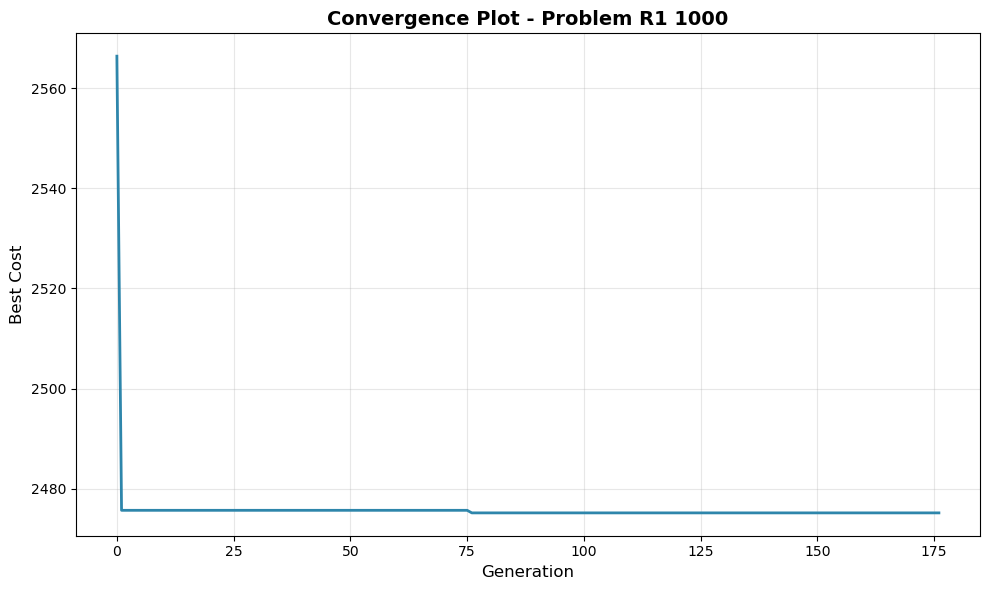

───────────────────────────────────────

[15/22] Processing problem_r2_10.npy


Generations without improvement:   0%|          | 0/100 [00:00<?, ?it/s]

Best cost found: -411.70


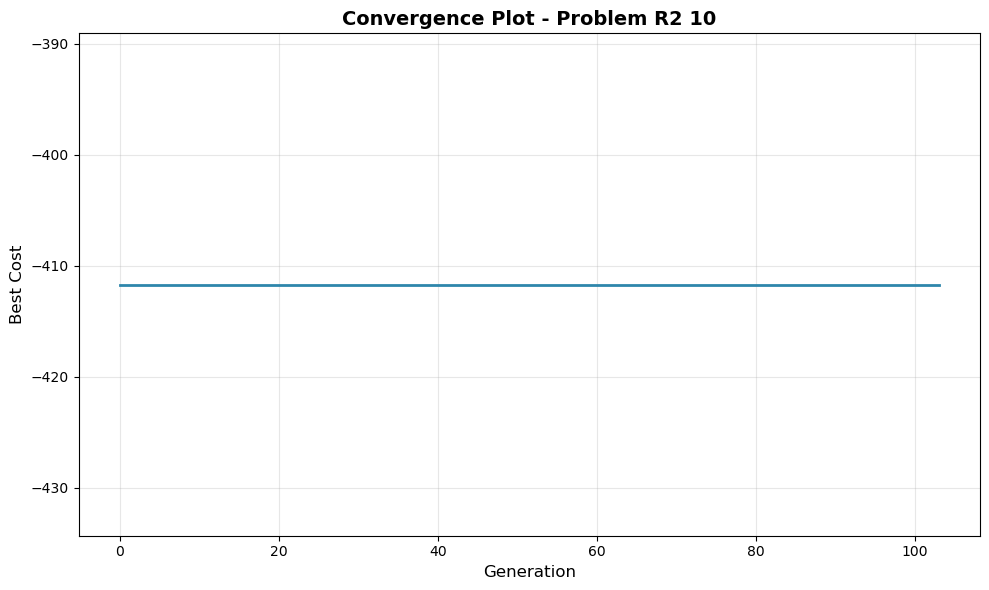

───────────────────────────────────────

[16/22] Processing problem_r2_20.npy


Generations without improvement:   0%|          | 0/100 [00:00<?, ?it/s]

Best cost found: -861.67


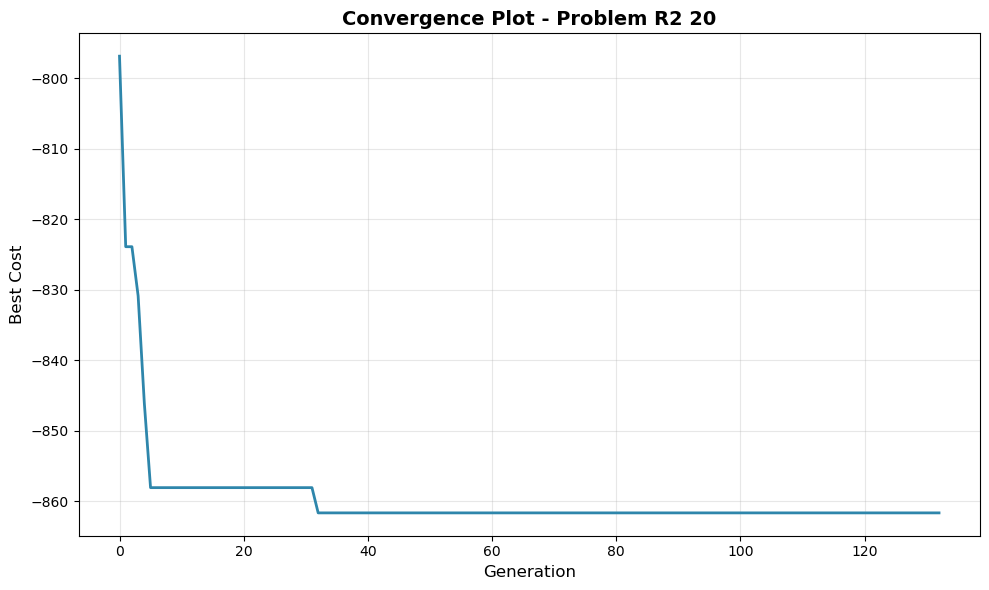

───────────────────────────────────────

[17/22] Processing problem_r2_50.npy


Generations without improvement:   0%|          | 0/100 [00:00<?, ?it/s]

Best cost found: -2291.62


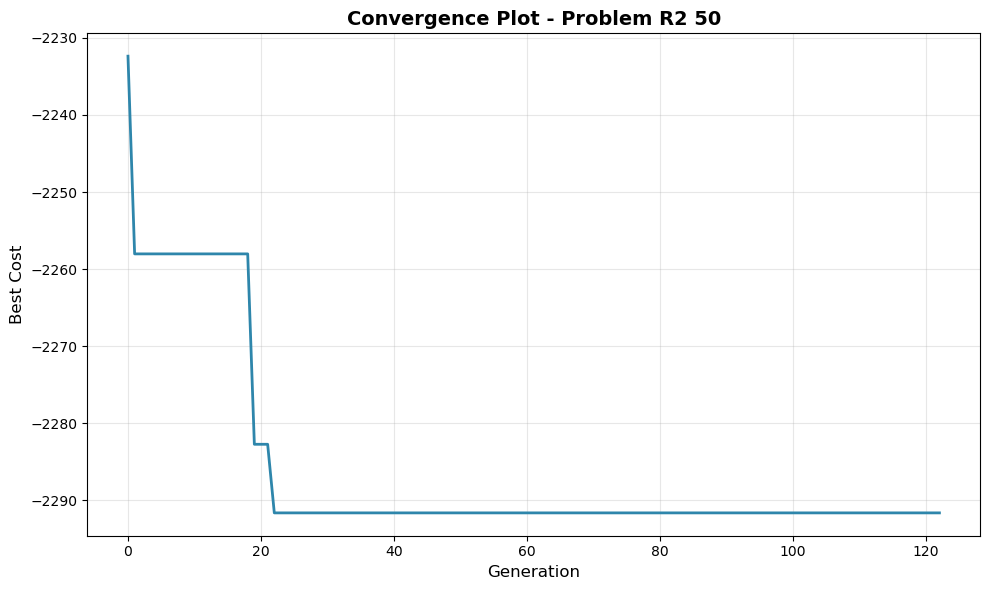

───────────────────────────────────────

[18/22] Processing problem_r2_100.npy


Generations without improvement:   0%|          | 0/100 [00:00<?, ?it/s]

Best cost found: -4692.44


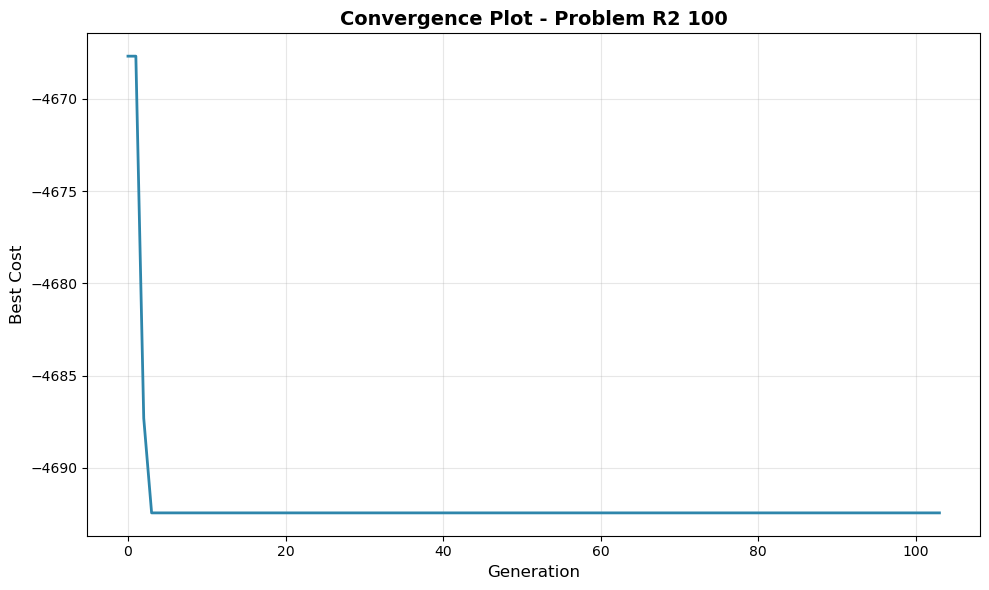

───────────────────────────────────────

[19/22] Processing problem_r2_200.npy


Generations without improvement:   0%|          | 0/100 [00:00<?, ?it/s]

Best cost found: -9615.70


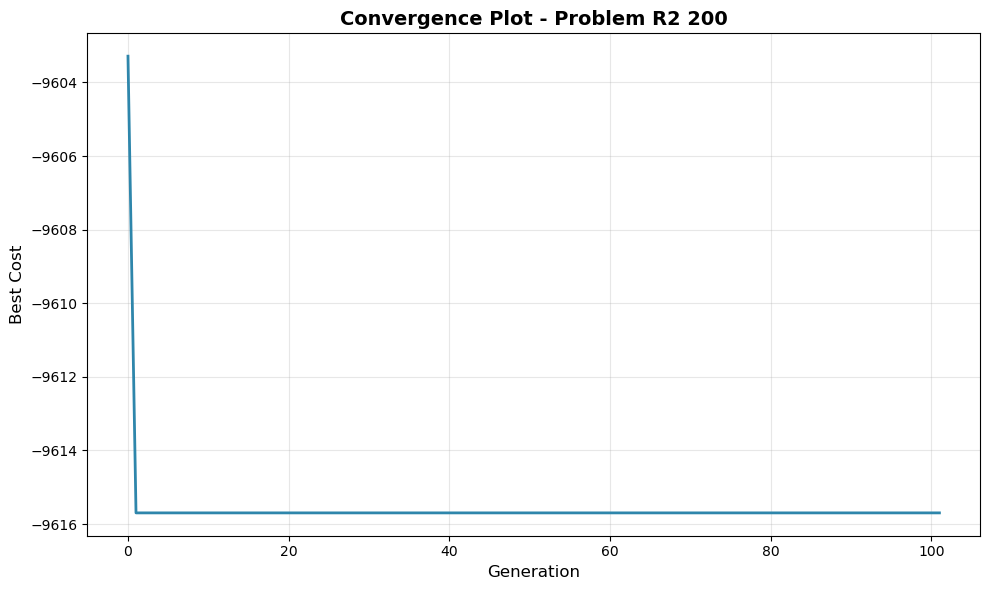

───────────────────────────────────────

[20/22] Processing problem_r2_500.npy


Generations without improvement:   0%|          | 0/100 [00:00<?, ?it/s]

Best cost found: -24610.29


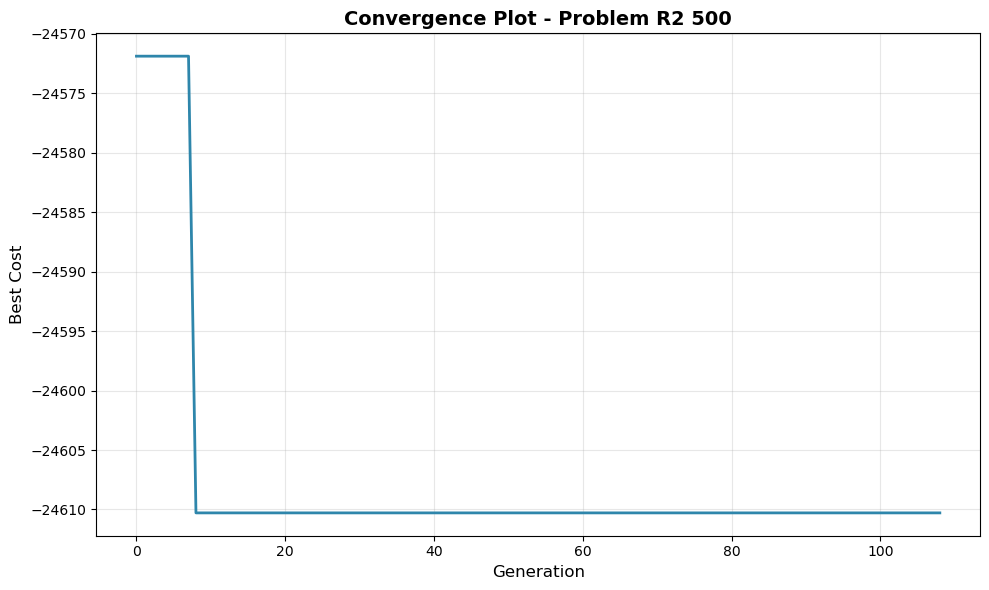

───────────────────────────────────────

[21/22] Processing problem_r2_1000.npy


Generations without improvement:   0%|          | 0/100 [00:00<?, ?it/s]

Best cost found: -49489.41


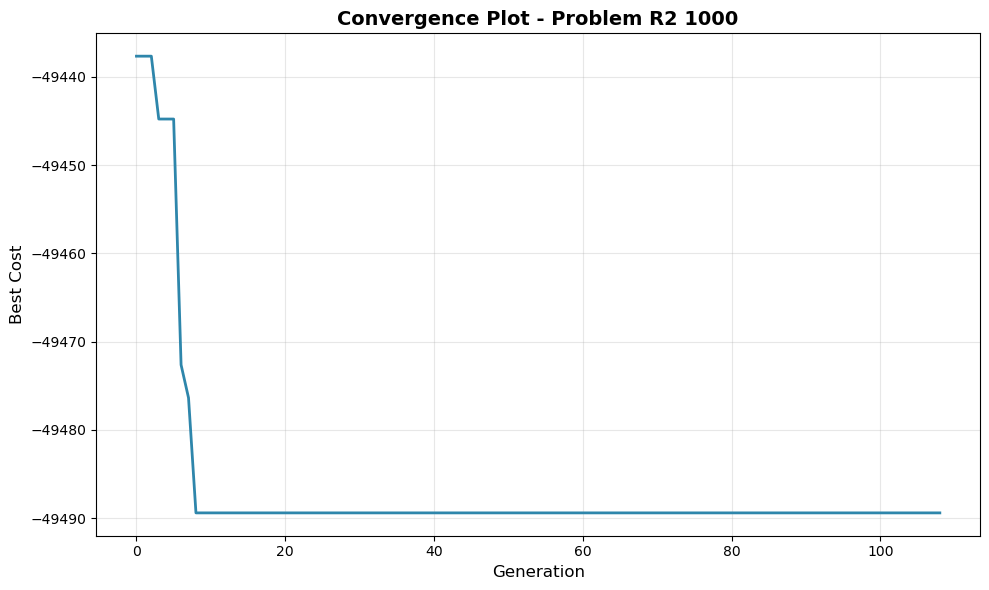

───────────────────────────────────────

[22/22] Processing test_problem.npy


Generations without improvement:   0%|          | 0/100 [00:00<?, ?it/s]

Best cost found: 2823.79


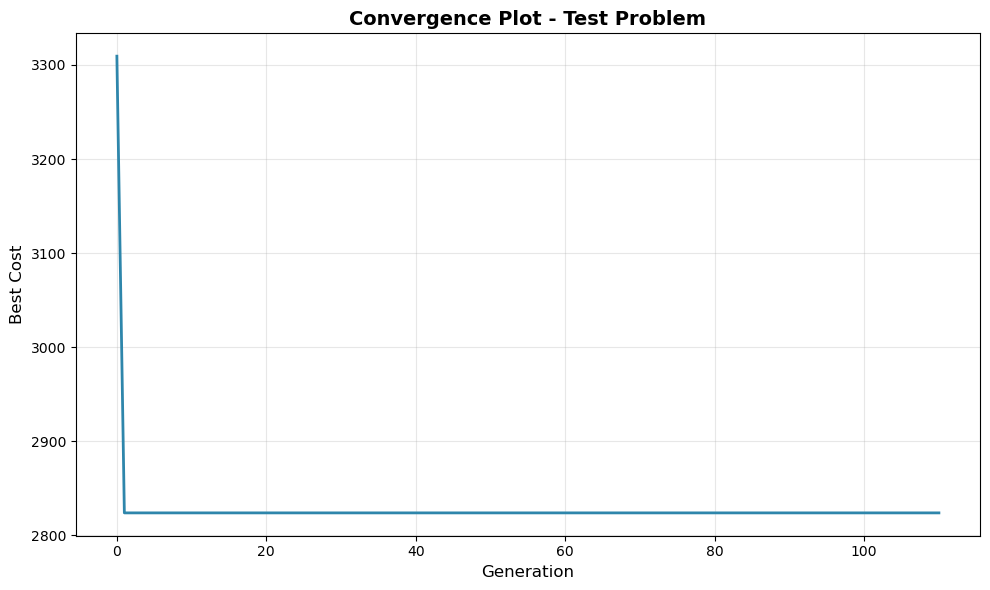

───────────────────────────────────────

═══════════════════════════════════════
       TSP Algorithm Evaluation        
    Total instances to solve: 22     
═══════════════════════════════════════


╔═══════════════════════════════════════╗
║            Final Results             ║
╚═══════════════════════════════════════╝
Problem Type  Cities Best Cost
           G      10   1497.66
           G      20   1755.51
           G      50   2629.99
           G     100   3968.01
           G     200   5645.48
           G     500   8928.05
           G    1000  12957.82
          R1      10    184.27
          R1      20    337.29
          R1      50    557.67
          R1     100    720.18
          R1     200   1027.21
          R1     500   1639.68
          R1    1000   2475.18
          R2      10   -411.70
          R2      20   -861.67
          R2      50  -2291.62
          R2     100  -4692.44
          R2     200  -9615.70
          R2     500 -24610.29
          R2    1000 -4

In [16]:
##############################
# SCRIPT GENERATE BY COPILOT #
##############################

# Initialize results collection
results = []

# Get all .npy files
npy_files = [f for f in os.listdir(NPY_FOLDER_PATH) if f.endswith('.npy')]

def get_file_info(filename):
    """Extract problem type and size from filename."""
    if filename == 'test_problem.npy':
        return ('test', 0)
    parts = filename.split('_')
    problem_type = parts[1]  # g, r1, r2
    size = int(parts[2].split('.')[0])  # number of cities
    return (problem_type, size)

# Sort files by type (g -> r1 -> r2 -> test) and then by size
npy_files.sort(key=lambda x: ('g r1 r2 test'.index(get_file_info(x)[0]), get_file_info(x)[1]))

print("═" * 39)
print("       TSP Algorithm Evaluation        ")
print(f"    Total instances to solve: {len(npy_files)}     ")
print("═" * 39 + "\n")

# Create directory for plots
os.makedirs('convergence_plots', exist_ok=True)

for i, file_name in enumerate(npy_files, 1):
    print(f"[{i}/{len(npy_files)}] Processing {file_name}")
    
    problem = np.load(os.path.join(NPY_FOLDER_PATH, file_name))
    best_cost, gen_history, cost_history = run_tsp_algorithm(problem)
    
    results.append({
        'Problem Type': get_file_info(file_name)[0].upper(),
        'Cities': get_file_info(file_name)[1] if get_file_info(file_name)[1] > 0 else len(problem),
        'Best Cost': f"{best_cost:.2f}"
    })
    print(f"Best cost found: {best_cost:.2f}")
    
    # Plot convergence
    problem_name = file_name.replace('.npy', '').replace('_', ' ').title()
    plot_save_path = os.path.join('convergence_plots', f"{file_name.replace('.npy', '')}_convergence.png")
    plot_convergence(gen_history, cost_history, problem_name, plot_save_path)
    
    print("─" * 39 + "\n")

print("═══════════════════════════════════════")
print("       TSP Algorithm Evaluation        ")
print(f"    Total instances to solve: {len(npy_files)}     ")
print("═══════════════════════════════════════\n")

# Display results table
df_results = pd.DataFrame(results)

print("\n╔═══════════════════════════════════════╗")
print("║            Final Results             ║")
print("╚═══════════════════════════════════════╝")
print(df_results.to_string(index=False))
print("\n" + "═" * 39)
print(f"\nConvergence plots saved in 'convergence_plots/' directory")